# Discovering and processing Earth Observation Data with the EO-MQS

The EO-MQS service is hosted within the C-SCALE federated cloud infrastructure and provides a unified way of discovering Copernicus data available within the federation by making use of the SpatioTemporal Asset Catalog (STAC) specification. The purpose of this notebook is to prvovide a concise introduction on how to use open-source Python libraries to search for geospatial data exposed by the EO-MQS STAC API.

## Prerequisites

In this example, we are going to make use of a popular STAC client for Python, the `pystac-client`. The library can be manually installed anywhere else via `pip install pystac-client`. 
Alternatively, common Python libraries like the `requests` library which support working with HTTP APIs are of course also well suited.

To get started, we need to import the `Client` class to connect to the EO-MQS which exposes its STAC API under `https://mqs.eodc.eu/stac/v1`.

In [1]:
pip install pystac-client

  Using cached pystac_client-0.6.1-py3-none-any.whl (30 kB)
  Using cached pystac-1.7.3-py3-none-any.whl (150 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import geopandas
from pystac_client import Client

client = Client.open("https://mqs.eodc.eu/stac/v1")
client.title

'C-SCALE Earth Observation Metadata Query Service (EO-MQS)'

In [3]:
# Define some useful functions
def get_search(collection: str, bbox = None) -> geopandas.geodataframe.GeoDataFrame:
    gpd = None
    try:
        results = client.search(collections=[collection], 
                            datetime=time_period, 
                            bbox=bbox,
                            limit=limit,
                            method="GET")
        _gpd = geopandas.GeoDataFrame.from_features(results.item_collection())
    except:
        print(f"Search for items with collection id {collection} failed or no items found.")
    else:
        gpd = _gpd
    return gpd        

def get_cloud_cover_ts(gdf: geopandas.geodataframe.GeoDataFrame) -> pd.core.series.Series:
    ts = None
    try:
        gdf["datetime"] = pd.to_datetime(gdf["datetime"])
        _ts = gdf.set_index("datetime").sort_index()["eo:cloud_cover"]
    except KeyError:
        print("eo:cloud_cover not available")
    else:
        ts = _ts 
    return ts

## CollectionClient

The client can be used to iterate through the Collections available in the EO-MQS Catalog. 

The `get_collections` method fetches the collections from the `/collections` endpoint and returns an iterable. To load a particular collection for further use we call the `get_collection(<collection_id>)` method below.

In [4]:
for collection in client.get_collections():
    print(collection)

<CollectionClient id=EODC|sentinel1-grd>
<CollectionClient id=EODC|sentinel-2-l1c>
<CollectionClient id=EODC|s1-global-sigma0>
<CollectionClient id=EODC|s1-demo-sigma0>
<CollectionClient id=EODC|landsat-c2-l1>
<CollectionClient id=EODC|s1-alps-wetsnow>
<CollectionClient id=EODC|austria-ground-motion>
<CollectionClient id=PSNC-Cloud|S5P_L2__NO2_RPRO>
<CollectionClient id=PSNC-Cloud|S5P_L2__HCHO_OFFL>
<CollectionClient id=PSNC-Cloud|S5P_L2__HCHO_NRTI>
<CollectionClient id=PSNC-Cloud|S5P_L2__SO2_OFFL>
<CollectionClient id=PSNC-Cloud|S5P_L2__CO_NRTI>
<CollectionClient id=PSNC-Cloud|S5P_L2__NO2_OFFL>
<CollectionClient id=PSNC-Cloud|S5P_L2__CLOUD_OFFL>
<CollectionClient id=PSNC-Cloud|S5P_L2__CLOUD_NRTI>
<CollectionClient id=PSNC-Cloud|S5P_L2__O3_NRTI>
<CollectionClient id=PSNC-Cloud|S5P_L2__AER_LH_NRTI>
<CollectionClient id=PSNC-Cloud|S5P_L2__O3_OFFL>
<CollectionClient id=PSNC-Cloud|S5P_L2__SO2_NRTI>
<CollectionClient id=PSNC-Cloud|S5P_L2__NO2_NRTI>
<CollectionClient id=PSNC-Cloud|S5P_L2__AE

On static as well as dynamic catalogues we cann also make use of the `links` attributes which lets us quickly examinate, for instance, the number of available collections.

In [5]:
child_links = client.get_links('child')
print(f"The EO-MQS currently features {len(child_links)} collections.")

The EO-MQS currently features 151 collections.


In [6]:
collection = client.get_collection("CollGS_CZ|sentinel-2-l1c-2023")
#collection = client.get_collection("sentinel-2-l1c")
collection

id: CollGS_CZ|sentinel-2-l1c-2023
title: sentinel-2-l1c-2023
description: MSI L1c. TOA Reflectances in Cartographic Geometry.
type: Collection
id: 5e79c26c-12c7-5df4-a563-b3f20bb03e0d
"bbox: [14.999717684492138, 49.55480005728169, 16.54932814673586, 50.55229211062575]"
productIdentifier: dhr3ca9c90d3-578a-400f-8732-276e020f1102
datetime: 2022-10-12T09:59:41.024000Z
start_datetime: 2022-10-12T09:59:41.024000Z
end_datetime: 2022-10-12T09:59:41.024000Z
"providers: [{'name': 'ESA', 'roles': ['producer', 'processor', 'licensor'], 'url': 'https://earth.esa.int/web/guest/home'}]"


One way how to access useful collection metadata programmatically: 

In [7]:
print(f"This collection contains data in the following temporal inteval: {collection.extent.temporal.to_dict()}")

This collection contains data in the following temporal inteval: {'interval': [['2018-03-26T09:40:29.027000Z', '2022-10-12T09:59:41.024000Z']], 'trs': 'http://www.opengis.net/def/uom/ISO-8601/0/Gregorian'}


## STAC Items

Simlarly to before, we can use the collection client instance to iterate over the items contained in the collection. The server must provide the `/collections/<collection_id>/items` endpoint to support this feature automatically. This can be useful to manually filter items or extract information programmatically. The `get_all_items()` method again returns an iterator.

## Visualize Sentinel-2 data over EU

In [8]:
import os
path = os.path.abspath("")

In [9]:
aoi_eu_wgs84 = geopandas.read_file(path + "/geojson/eu_wgs84.geojson")

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [10]:
time_period = "2020-01-01/.."
limit = 50

In [11]:
s2_collections = []
for collection in client.get_collections():
    if "l1c" in collection.id.lower():
        print(f"Append collection {collection.id} to list of Sentinel-2 L1C collections.")
        s2_collections.append(collection.id)

Append collection EODC|sentinel-2-l1c to list of Sentinel-2 L1C collections.
Append collection CollGS_CZ|sentinel-2-l1c to list of Sentinel-2 L1C collections.
Append collection CollGS_CZ|sentinel-2-l1c-2023 to list of Sentinel-2 L1C collections.
Append collection VITO|urn:eop:VITO:CGS_S2_L1C to list of Sentinel-2 L1C collections.
Append collection VITO|urn:eop:VITO:PROBAV_L1C_HDF_V2 to list of Sentinel-2 L1C collections.


In [12]:
# using format of collection in order to define new varibale with proper format.
for i in range(0,len(s2_collections)):
    collections_item = client.get_collection(s2_collections[i])
    print(f"{collections_item.id} collection contains data in the following temporal inteval: {collections_item.extent.temporal.to_dict()}")

EODC|sentinel-2-l1c collection contains data in the following temporal inteval: {'interval': [['2015-07-04T00:00:00Z', None]]}
CollGS_CZ|sentinel-2-l1c collection contains data in the following temporal inteval: {'interval': [['2016-11-19T09:53:12.026000Z', '2022-12-15T09:44:11.024000Z']], 'trs': 'http://www.opengis.net/def/uom/ISO-8601/0/Gregorian'}
CollGS_CZ|sentinel-2-l1c-2023 collection contains data in the following temporal inteval: {'interval': [['2018-03-26T09:40:29.027000Z', '2022-10-12T09:59:41.024000Z']], 'trs': 'http://www.opengis.net/def/uom/ISO-8601/0/Gregorian'}
VITO|urn:eop:VITO:CGS_S2_L1C collection contains data in the following temporal inteval: {'interval': [['2017-06-15T00:00:00Z', None]]}
VITO|urn:eop:VITO:PROBAV_L1C_HDF_V2 collection contains data in the following temporal inteval: {'interval': [['2013-10-16T00:00:00Z', '2020-06-30T23:59:59Z']]}


In [13]:
# Get bbox coordinates to accelerate serach
bbox_eu = aoi_eu_wgs84.bounds.values.tolist()[0]
bbox_eu

[-63.151187329826996,
 -21.349632697207902,
 55.834818182891276,
 70.09213659004354]

In [14]:
dataS = get_search(s2_collections[0],bbox=bbox_eu)
for n in range(1,len(s2_collections)):
    sets = get_search(s2_collections[n], bbox=bbox_eu)
    dataS = pd.concat([dataS, sets])

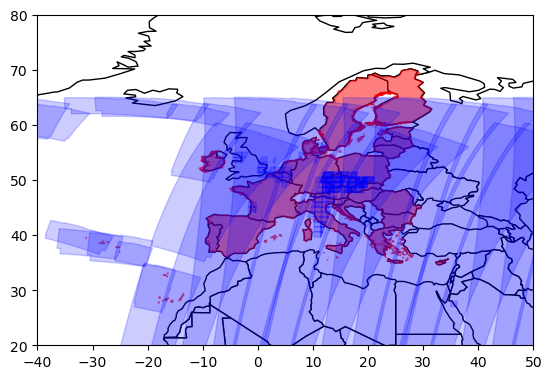

In [15]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
aoi_eu_wgs84.plot(ax=ax, edgecolor='red', facecolor="red", alpha=0.5, linewidth=1)
dataS.plot(ax=ax, edgecolor='blue', facecolor="blue", alpha=0.2, linewidth=1)
ax.set_xlim([-40,50])
ax.set_ylim([20,80])
plt.show()

In [16]:
df_eodc_1 = get_search(s2_collections[0], bbox=bbox_eu)   #"EODC|sentinel-2-l1c"
df_cesnet_1 = get_search(s2_collections[1], bbox=bbox_eu) #"CollGS_CZ|sentinel-2-l1c"
df_cesnet_2 = get_search(s2_collections[2], bbox=bbox_eu) #CollGS_CZ|sentinel-2-l1c-2023
df_vito_1 = get_search(s2_collections[3], bbox=bbox_eu)   #"VITO|urn:eop:VITO:CGS_S2_L1C"

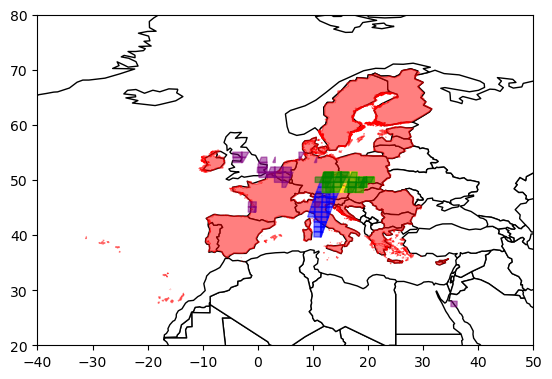

In [17]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
aoi_eu_wgs84.plot(ax=ax, edgecolor='red', facecolor="red", alpha=0.5, linewidth=1)
df_eodc_1.plot(ax=ax, edgecolor='blue', facecolor="blue", alpha=0.5, linewidth=1)
df_cesnet_1.plot(ax=ax, edgecolor='yellow', facecolor="yellow", alpha=0.5, linewidth=1)
df_cesnet_2.plot(ax=ax, edgecolor='green', facecolor="green", alpha=0.5, linewidth=1)
df_vito_1.plot(ax=ax, edgecolor='purple', facecolor="purple", alpha=0.5, linewidth=1)
ax.set_xlim([-40,50])
ax.set_ylim([20,80])
plt.show()

## Item Search

Data providers that have realized their STAC implementation in terms of a dynamic STAC API offer users the opportunity to search their Catalogs using spatial and temporal constraints. The `pystac_client` enables this search via the class method `search`. This function returns an ItemSearch instance that can further be accessed to retrieve matched items.

Note that in its current implementation, the EO-MQS supports the *core* STAC search endpoint paramters as described in the [STAC API - Item Search](https://github.com/radiantearth/stac-api-spec/tree/master/item-search#query-parameter-table) specification. Those are:
- limit
- bbox
- datetime
- intersects
- ids
- collections

### Search for Sentinel-2 data intersecting a GeoJSON object

The second example makes use of the `intersects` and the `collections` parameters. Note that you cannot specify both `bbox` and `intersects`, this will result in an error.

We can quickly create region of interest at [geojson.io](https://geojson.io).

In [18]:
time_period = "2015-01-01/2016-01-01"
limit = 100

In [19]:
import json

with open(path + '/geojson/utrecht_map.geojson') as f:
    geo = json.load(f)

In [20]:
geom = geo['features'][0]['geometry']
geom

{'coordinates': [[[5.04603136455745, 52.16762259800265],
   [5.043056178931636, 52.18586785918882],
   [5.033535584930917, 52.18586785918882],
   [5.037700844805926, 52.199729253026135],
   [5.024014990928691, 52.20410563742175],
   [5.037700844805926, 52.20483499292314],
   [5.041866104682498, 52.23290607824782],
   [5.060907292685329, 52.237643601998684],
   [5.04662640168354, 52.245295456921184],
   [5.04127106755638, 52.25804561675142],
   [5.0353206963061155, 52.25403881852557],
   [5.023419953802687, 52.27479739705794],
   [5.066262626811067, 52.28280688090675],
   [5.059717052818286, 52.29081464929945],
   [5.051386533066733, 52.28790280350586],
   [5.043651050439792, 52.28426272712471],
   [5.031155270813173, 52.28972272955485],
   [5.024609862436819, 52.282806612837845],
   [5.021634676811004, 52.303915587084134],
   [5.0091388971829645, 52.303915587084134],
   [4.999023266056184, 52.29045067904147],
   [4.984742375052917, 52.291178616567066],
   [4.969271409800427, 52.2820785

In [21]:
results_VITO = client.search(collections = ["VITO|urn:eop:VITO:CGS_S2_L1C"],
                        intersects = geom,
                        datetime = time_period,
                        limit = limit,
                        method = "POST")

In [22]:
items_VITO = results_VITO.item_collection()

print(f"We found {len(items_VITO)} matching items.")

We found 19 matching items.


In [23]:
items_VITO[17]

id: urn:eop:VITO:CGS_S2_L1C:S2A_MSIL1C_20150716T105026_N0204_R051_T31UFT_20150716T105024
"bbox: [4.4361206, 51.3245234, 6.0777579, 52.3413551]"
datetime: 2015-07-16T10:50:26.027Z
title: S2A_MSIL1C_20150716T105026_N0204_R051_T31UFT_20150716T105024
created: 2021-02-26T11:41:15Z
updated: 2019-10-22T11:48:25.197Z
start_datetime: 2015-07-16T10:50:26.027Z
end_datetime: 2015-07-16T10:50:26.027Z
platform: Sentinel-2
href: https://services.terrascope.be/download/CGS_S2_L1C/2015/07/16/S2A_MSIL1C_20150716T105026_N0204_R051_T31UFT_20150716T105024/S2A_MSIL1C_20150716T105026_N0204_R051_T31UFT_20150716T105024.SAFE/GRANULE/L1C_T31UFT_A000334_20150716T105024/QI_DATA/T31UFT_20150716T105026_PVI.jp2
type: image/jp2


NOTE: You can always visualize STAC data (collections, items, etc.) in external tools like the STAC Browser, for instance do the following:

In [24]:
print(f"Look at this item in the STAC Browser: https://radiantearth.github.io/stac-browser/#/external/{items_VITO[0].get_self_href()}")

Look at this item in the STAC Browser: https://radiantearth.github.io/stac-browser/#/external/https://mqs.eodc.eu/stac/v1/collections/VITO|urn:eop:VITO:CGS_S2_L1C/items/urn:eop:VITO:CGS_S2_L1C:S2A_MSIL1C_20151230T104442_N0201_R008_T31UFT_20151230T104440


In [25]:
i = 17
url=items_VITO[i].assets['QUICKLOOK'].href
url

'https://services.terrascope.be/download/CGS_S2_L1C/2015/07/16/S2A_MSIL1C_20150716T105026_N0204_R051_T31UFT_20150716T105024/S2A_MSIL1C_20150716T105026_N0204_R051_T31UFT_20150716T105024.SAFE/GRANULE/L1C_T31UFT_A000334_20150716T105024/QI_DATA/T31UFT_20150716T105026_PVI.jp2'

In [26]:
quick_look = requests.get(url, stream=True)

In [27]:
import rasterio
import rasterio.plot as plot
from rasterio.plot import show

with open(path + '/quick.jp2', 'wb') as f:
    f.write(quick_look.content)

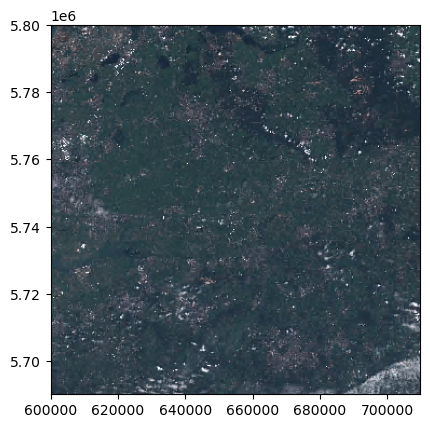

<AxesSubplot: >

In [28]:
quick_tci = rasterio.open(path + '/quick.jp2', driver='JP2OpenJPEG');
show(quick_tci)

In [29]:
## If the item provides a preview image we can look at it in here using the following code

#from IPython.display import Image
#Image(url=url, width=500)

### Search for Sentinel-2 data using bbox 

This first example makes use of the `bbox`, `datetime` and the `collections` parameters. Learn about the correct formatting of these values on the STAC Spec GitHub page or by looking at the [pystac-client docs](https://pystac-client.readthedocs.io/en/latest/api.html#item-search).

In [34]:
time_period = "2022-01-01/2023-01-06"
time_period

'2022-01-01/2023-01-06'

In [61]:
prague = geopandas.read_file(path + "/geojson/prague_map.geojson")

In [62]:
# Get bbox coordinates to accelerate serach
bbox = prague.bounds.values.tolist()[0]
bbox

[14.214604980199539, 49.932314092081214, 14.72548605776879, 50.18652586156733]

In [37]:
items_s2 = []
items_s2dict = {}
for collection in s2_collections:
    results_s2 = client.search(collections=[collection], 
                            bbox=bbox, 
                            datetime=time_period, 
                            limit=limit,
                            method="GET")
    try:
        items_s2.extend(results_s2.item_collection())
        items_s2dict[f"{collection}"] = results_s2.item_collection()
        print(f"Search for items with collection id {collection} was succesfull.")
    except:
        print(f"Search for items with collection id {collection} failed.")

Search for items with collection id EODC|sentinel-2-l1c was succesfull.
Search for items with collection id CollGS_CZ|sentinel-2-l1c was succesfull.
Search for items with collection id CollGS_CZ|sentinel-2-l1c-2023 was succesfull.
Search for items with collection id VITO|urn:eop:VITO:CGS_S2_L1C failed.
Search for items with collection id VITO|urn:eop:VITO:PROBAV_L1C_HDF_V2 failed.


In [38]:
print(f"{len(items_s2)} matching items was found.")

202 matching items was found.


In [39]:
items_s2dict["CollGS_CZ|sentinel-2-l1c-2023"]

id: 4b53ea1a-55a3-5d33-9217-8ead7d80b3a1
"bbox: [13.791291456622401, 49.55742916419701, 15.137769755767613, 50.552210622261306]"
productIdentifier: dhr35993b335-992d-4927-98ef-bf301a02d5b4
datetime: 2022-10-12T09:59:41.024000Z
start_datetime: 2022-10-12T09:59:41.024000Z
end_datetime: 2022-10-12T09:59:41.024000Z
"providers: [{'name': 'ESA', 'roles': ['producer', 'processor', 'licensor'], 'url': 'https://earth.esa.int/web/guest/home'}]"
platform: Sentinel-2A
constellation: Sentinel 2
instruments: ['msi']
eo:cloud_cover: 9.4611649115443


In [40]:
gpd = {}
cloud_dict = {}

for i in items_s2dict:
    gpd[f"{i}"] = geopandas.GeoDataFrame.from_features(items_s2dict[i])
    cloud_dict[f"{i}"] = get_cloud_cover_ts(gpd[i])

In [41]:
cloud_dict["CollGS_CZ|sentinel-2-l1c-2023"]

datetime
2022-01-10 10:02:59.024000+00:00    99.996200
2022-01-15 10:03:51.024000+00:00    18.462700
2022-01-18 10:13:41.024000+00:00    53.383100
2022-01-20 10:02:29.024000+00:00    88.963900
2022-01-23 10:12:19.024000+00:00    67.176200
                                      ...    
2022-10-02 10:00:31.024000+00:00    85.997203
2022-10-05 10:09:01.024000+00:00    99.991131
2022-10-07 10:00:29.024000+00:00    25.775029
2022-10-10 10:08:39.024000+00:00    30.513273
2022-10-12 09:59:41.024000+00:00     9.461165
Name: eo:cloud_cover, Length: 100, dtype: float64

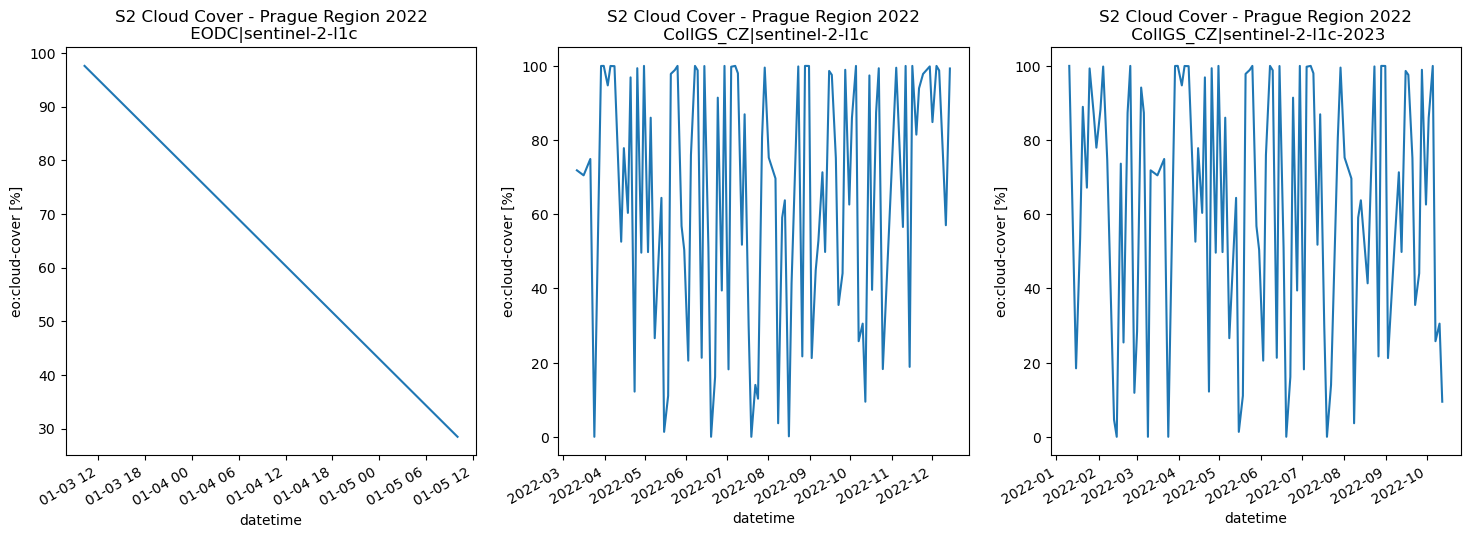

In [43]:
import matplotlib.dates as mdates

plotype = "line"
title = 'S2 Cloud Cover - Prague Region 2022'
yaxis = 'eo:cloud-cover [%]'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

for i, item in enumerate(cloud_dict):
    cloud_dict[item].plot(ax=axes[i],                          
                          kind=plotype,
                          ylabel= yaxis,
                          title= title + '\n' + f" {item}")

In [44]:
time_period = "2022-01-01/2022-12-31"
limit = 100

In [45]:
results_2023 = client.search(collections=["CollGS_CZ|sentinel-2-l1c-2023"], 
                            bbox=bbox, 
                            datetime=time_period, 
                            limit=limit,
                            method="GET")

In [46]:
items_CollGS_CZ = results_2023.item_collection()

print(f"We found {len(items_CollGS_CZ)} matching items.")

We found 100 matching items.


In [47]:
# Load 10 items with cloud cover less than 10%
items_cloud = []
for n, item in enumerate(items_CollGS_CZ):
    if len(items_cloud) == 10:
        break
    cloud_cover = item.properties.get("eo:cloud_cover")
    if cloud_cover < 10:
        print(f"Append item {item.id} with {cloud_cover:.2f}% cloud cover")
        items_cloud.append(item)

Append item 4b53ea1a-55a3-5d33-9217-8ead7d80b3a1 with 9.46% cloud cover
Append item 3a1ba79c-c20b-54de-8f11-9808beeed98f with 3.65% cloud cover
Append item fccdda90-a9e2-5933-9f68-875496f3d951 with 0.00% cloud cover
Append item 13214da3-9afa-5094-90f1-a7838a5ac665 with 0.01% cloud cover
Append item 6875ad60-c852-5dbd-9b3e-4df9cdff3146 with 1.33% cloud cover
Append item 056100b7-11a8-5fdd-87d8-85489828cc78 with 1.33% cloud cover
Append item 90a55e2b-1202-5a6b-b0b3-c2c483fb218c with 0.00% cloud cover
Append item 2a547212-a8eb-56bb-aa47-b5634e12979c with 0.00% cloud cover
Append item 8e66abe7-b284-5e50-9751-1e7dcffd00f8 with 0.00% cloud cover
Append item 0b5e3d62-ce2c-58de-9673-c31dce37c5bf with 4.63% cloud cover


In [48]:
low_cloud = 7
items_cloud[low_cloud]

id: 2a547212-a8eb-56bb-aa47-b5634e12979c
"bbox: [13.58808613662857, 49.55648784343155, 15.137769755767613, 50.552210622261306]"
productIdentifier: dhr3cccdb32f-d82a-4ded-b1ff-8efb5d5571e9
datetime: 2022-03-09T10:08:41.024000Z
start_datetime: 2022-03-09T10:08:41.024000Z
end_datetime: 2022-03-09T10:08:41.024000Z
"providers: [{'name': 'ESA', 'roles': ['producer', 'processor', 'licensor'], 'url': 'https://earth.esa.int/web/guest/home'}]"
platform: Sentinel-2A
constellation: Sentinel 2
instruments: ['msi']
eo:cloud_cover: 0


In [50]:
print(f"Look at this item in the STAC Browser: https://radiantearth.github.io/stac-browser/#/external/{items_cloud[low_cloud].get_self_href()}")

Look at this item in the STAC Browser: https://radiantearth.github.io/stac-browser/#/external/https://mqs.eodc.eu/stac/v1/collections/CollGS_CZ|sentinel-2-l1c-2023/items/2a547212-a8eb-56bb-aa47-b5634e12979c


In [51]:
url=items_cloud[low_cloud].assets["visual"].href
url

"https://dhr3.cesnet.cz/odata/v1/Products('cccdb32f-d82a-4ded-b1ff-8efb5d5571e9')//Nodes(%27S2A_MSIL1C_20220309T100841_N0400_R022_T33UVR_20220309T110358.SAFE%27)/Nodes(%27GRANULE%27)/Nodes(%27L1C_T33UVR_A035054_20220309T101114%27)/Nodes(%27IMG_DATA%27)/Nodes(%27T33UVR_20220309T100841_TCI.jp2%27)/%24value"

In [52]:
access_token = open('/var/run/secrets/egi.eu/access_token').read()
r = requests.get("https://aai.egi.eu/auth/realms/egi/protocol/openid-connect/userinfo", headers={"authorization": "Bearer {}".format(access_token)}, stream=True)
r

<Response [200]>

In [53]:
print(json.dumps(json.loads(r.content), indent=2))

{
  "sub": "b10d032648d03b75a24a779533376e2376f9de61508522bce083ed850492b13a@egi.eu",
  "voperson_verified_email": [
    "Petr.Pospisil@cesnet.cz"
  ],
  "email_verified": true,
  "name": "Petr Posp\u00ed\u0161il",
  "eduperson_scoped_affiliation": [
    "employee@cesnet.cz",
    "member@cesnet.cz"
  ],
  "eduperson_assurance": [
    "https://refeds.org/assurance/ID/unique",
    "https://refeds.org/assurance/IAP/high",
    "https://refeds.org/assurance/IAP/low",
    "https://aai.egi.eu/LoA#Substantial"
  ],
  "preferred_username": "ppospisil",
  "given_name": "Petr",
  "family_name": "Posp\u00ed\u0161il",
  "eduperson_entitlement": [
    "urn:mace:egi.eu:group:vo.notebooks.egi.eu:role=admin#aai.egi.eu",
    "urn:mace:egi.eu:group:vo.notebooks.egi.eu:role=member#aai.egi.eu",
    "urn:mace:egi.eu:group:vo.notebooks.egi.eu:role=vm_operator#aai.egi.eu",
    "urn:mace:egi.eu:group:vo.notebooks.egi.eu:admins:role=member#aai.egi.eu",
    "urn:mace:egi.eu:group:vo.notebooks.egi.eu:admins:role=

In [54]:
TCI = requests.get(url, headers={"authorization": "Bearer {}".format(access_token)}, stream=True)

In [55]:
import os
img_folder = path + "/images/jp2/"
if os.path.isdir(img_folder) != True:
    os.mkdir(img_folder)

In [56]:
img_name = "TCI.jp2"

In [57]:
with open(img_folder + img_name, 'wb') as f:
    f.write(TCI.content)

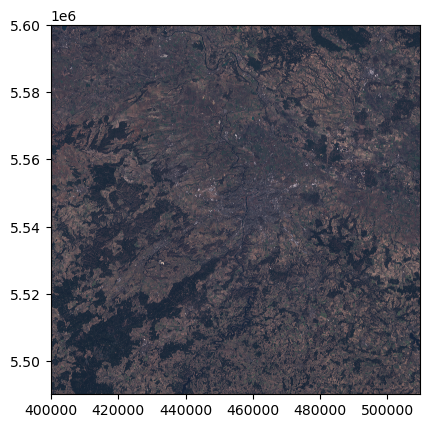

CPU times: user 5min 43s, sys: 1min 21s, total: 7min 5s
Wall time: 3min 45s


<AxesSubplot: >

In [58]:
%%time
import rasterio
from rasterio.plot import show
tci = rasterio.open(img_folder + img_name, driver='JP2OpenJPEG');
show(tci)

In [59]:
band_list = []
for i in range(2,13):
    if i < 10:
        band_list.append("B0" + str(i))
        if i == 8:
            band_list.append("B8A")
    else:
        band_list.append("B" + str(i))
band_list

['B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B8A',
 'B09',
 'B10',
 'B11',
 'B12']

In [60]:
for band in band_list:
    url=items_cloud[low_cloud].assets[band].href
    img = requests.get(url, headers={"authorization": "Bearer {}".format(access_token)}, stream=True)
    with open(img_folder + band +'.jp2', 'wb') as f:
        f.write(img.content)